In [284]:
# This notebook has functions to simulate 1D and 2D CTFs, and create simulated through-focus series
# The CTF can be varied as a function of defocus, Cc, Cs, and kV
# The maximum spatial frequency is set as flim
# The image size for 2D CTFs is set, and the pixel size worked out from the maximum spatial frequency

In [310]:
# import dependancies
import math
#import scipy.constants
import numpy as np
import matplotlib.pyplot as plt

In [311]:
#other functions
def normaliseDataRange( data ):
    return (data-np.min(data))/(np.max(data)-np.min(data))

## functions for plotting
def plotSettings( fig, ax ):
    ax.set_xlim(0, flim*1e9)
    ax.set_yticks([0, 1])
    ax.legend()
    ax.set_ylabel('Intensity', fontsize = 16)
    ax.set_xlabel('Frequency / nm-1', fontsize = 16)
    ax.set_box_aspect(1)
    fig.tight_layout()
    return

def calculate_scherzer( Cs, lamb ):
    scherzer = np.sqrt((4/3)*Cs*lamb)
    return scherzer

def kVToLamb(E):
    # calculate relativistic wavelength from kV 
    E = E*1000
    PT = scipy.constants.h * scipy.constants.c
    PBA = (scipy.constants.e *E)*(scipy.constants.e *E)
    PBB = 2*scipy.constants.e*E*scipy.constants.m_e*(scipy.constants.c)*(scipy.constants.c)
    lamb = PT/math.sqrt(PBA+PBB)#lambda in metres
    return lamb

In [312]:
# 1D CTF functions
def calculateFrequencyRange( fno, flim ):
    frequency = [0 for _ in range(fno)]
    for i in n:
        frequency[i] = float( (flim) * i/fno )
    return frequency
    
def calculate_CTF( frequency, defocus, lamb, Cs, C12a, C12b, phi, flim, fno ):
    CTF = [0 for _ in range(fno)]
    for i in n:
        f = frequency[i]
        CTF[i] = np.sin((np.pi*defocus*lamb*(f**2)) 
                        +(0.5*np.pi*Cs*(lamb**3)*(f**4)) 
                        +np.pi*lamb*(f**2)*(C12a*np.cos(2*phi) + C12b*np.sin(2*phi) ) )
        frequency[i] = f
    return CTF

def aperture_function( cutoff, CTF, frequency ):
    aperture = np.zeros(len(CTF))
    n = range(0, len(aperture ))
    for i in n:
        if frequency[i] < cutoff:
            aperture[i] = 1
        if frequency[i] >= cutoff:
            aperture[i] = 0
    return aperture

def temporal_coherence( focal_spread, kV, CTF, flim, fno, Cc ):
    # in eV
    #deltaE = 1.5 #1.5 for 2100plus
    # current
    #deltaI = 1
    #I = 1
    # volts
    #deltaV = 2e-6  #2e-6 # for plus2e-6
    V = kV * 1000
    #delta = Cc * np.sqrt( 4* ((deltaI/I)**2) * ((deltaE/V)**2) * ((deltaV/V)**2) )# spatial units
    delta = Cc * (focal_spread / V)
    Et = np.zeros(len(CTF))
    n = range(0, len( Et ))
    for i in n:
        f = float(flim*(i/fno))
        Et[i] = np.exp( -0.25*(( np.pi* lamb * delta)**2) * f**4)
    return Et

def spatial_coherence( beta, defocus, CTF, lamb, Cs, flim, fno ):
    Es = np.zeros(len(CTF))
    dChi = np.zeros(len(CTF))
    n = range(0, len( Es ))
    for i in n:
        f = float(flim*(i/fno))
        dChi[i] = (2*np.pi*lamb*f*defocus) + (2*np.pi*Cs*(lamb**3)*(f**3))
        Es[i] = np.exp( -(beta / ((4*(lamb**2)))) * abs(dChi[i])**2 )
    return Es

# master function for CTF simulation
def simulate1DCTF( lamb, flim, fno, **kwargs ):
    focal_spread = kwargs.get('focal_spread', 5.25)
    Cs = kwargs.get('Cs', 1.6)*1e-3
    Cc = kwargs.get('Cc', 1.6)*1e-3
    defocus = kwargs.get('defocus', 0)*1e-9
    C12a = kwargs.get('C12a', 0 )*1e-9
    C12b = kwargs.get('C12b', 0 )*1e-9
    phi = kwargs.get('phi', 0 )
    beta = kwargs.get('beta', 0 )*1e-3
    cutoff = kwargs.get('cutoff', flim )*1e9
    kV = kwargs.get('voltage', 200 )
    flim = flim*1e9
    n = range(0,fno)
    # frequency range and  CTF
    frequency = calculateFrequencyRange( fno, flim )
    CTF = calculate_CTF( frequency, defocus, lamb, Cs, C12a, C12b, phi, flim, fno )
    # damping functions
    aperture = aperture_function( cutoff, CTF, frequency )
    Et = temporal_coherence( focal_spread, kV, CTF, flim, fno, Cc )
    Es = spatial_coherence( beta, defocus, CTF, lamb, Cs, flim, fno )
    # damped CTF and square CTF
    dampedCTF = CTF * aperture * Es * Et
    squareCTF = np.square( dampedCTF )
    return CTF, dampedCTF, squareCTF, Es, Et, aperture, frequency

In [313]:
# 2D CTF
def simulate2DCTF( lamb, flim, **kwargs ):
    image_size = kwargs.get('size', int(128) )
    defocus = kwargs.get('defocus', 0.0)*1e-9
    focal_spread = kwargs.get('focal_spread', 5.25)
    Cs = kwargs.get('Cs', 1.6)*1e-3
    Cc = kwargs.get('Cc', 1.6)*1e-3
    C12a = kwargs.get('C12a', 0.0 )*1e-9
    C12b = kwargs.get('C12b', 0.0 )*1e-9
    beta = kwargs.get('beta', 0.0 )*1e-3
    cutoff = kwargs.get('cutoff', flim )*1e9
    kV = kwargs.get('voltage', 200 )
    flim = flim*1e9
    # arrays to hold 2d data
    imageX = imageY = image_size  
    radius = imageX/2
    CTF2d = np.ones((imageX,imageY))
    irow, icol = np.indices(CTF2d.shape)
    centX = irow - CTF2d.shape[0] / 2.0
    centY = icol - CTF2d.shape[1] / 2.0
    #distance from centre
    iradius = (centX**2 + centY**2)**0.5
    #angle from centre
    itheta = np.arctan2(centX, centY)
    # distance per pixel
    scale = image_size / flim
    # scale iradius to spatial frequncy
    iradius = iradius / scale # check that distance units are set right here
    ## 2D CTF ##
    CTF2d = np.sin( (np.pi*defocus*lamb*(iradius**2) ) + (np.pi*Cs*(lamb**3)*(iradius**4)) +
                    np.pi*lamb*(iradius**2)*(C12a*np.cos(2*itheta) + C12b*np.sin(2*itheta) ))
    ## Damping functions ##
    # Aperture function
    Aperture2d = create2DAperture( imageX, imageY, cutoff, iradius )
    # Temporal coherence
    Et2d = create2DTemporal( Cc, focal_spread, kV, iradius )
    # Spatial coherence
    Es2d = creat2DSpatial( lamb, iradius, defocus, Cs )
    ## damped and square CTF ##
    damped = ( CTF2d * Es2d * Et2d * Aperture2d )
    squared = damped * damped
    return CTF2d, squared

def create2DTemporal( Cc, focal_spread, kV, iradius ):
    delta = Cc * (focal_spread / (kV * 1000))
    Et2d = np.exp( -0.25*(( np.pi* lamb * delta)**2) * (iradius**4) )
    return Et2d
    
    # Spatial coherence
def creat2DSpatial( lamb, iradius, defocus, Cs ):
    #derivative of CTF
    dChi_2d = (2*np.pi*lamb*iradius*defocus) + (2*np.pi*Cs*(lamb**3)*(iradius**3))# really small numbers for some reason
    Es2d = np.exp( -(beta / ((4*lamb**2))) * abs(dChi_2d)**2 )
    return Es2d
    
def create2DAperture( imageX, imageY, cutoff, iradius ):
    # Aperture function
    Aperture2d = np.ones((imageX,imageY))
    n = range(0, len(Aperture2d[0] ))
    m = range(0, len(Aperture2d[1] ))
    for i in n:
        for j in m:
            if iradius[i,j] < cutoff:
                Aperture2d[i,j] = 1
            if iradius[i,j] >= cutoff:
                Aperture2d[i,j] = 0
    return Aperture2d

In [314]:
# simulate CTFs
# wavelength, calculated from the accelerating voltage in kV
lamb = kVToLamb( 200 )
# negative is underfocus, positive is overfocus
scherzer_defocus = calculate_scherzer( 1.8, lamb )
# focal spread
focal_spread = 5.25
# semi-angle, mrad
beta = 0
# frequency limit of simulation, nm-1
flim = 5
# number of datapoints in simulation
fno = int(2000)
# frequency cutoff for aperture function, in nm-1
cutoff = flim

CTF, dampedCTF, squareCTF, Es, Et, aperture, frequency = simulate1DCTF( 
    lamb, flim, fno, defocus=-200, Cs=1.8)

CTF2d, square2DCTF = simulate2DCTF( lamb, flim, defocus=-200, Cs=1.8, C12a=0, C12b=0,
                                  size=int(256), voltage=250 )

[]

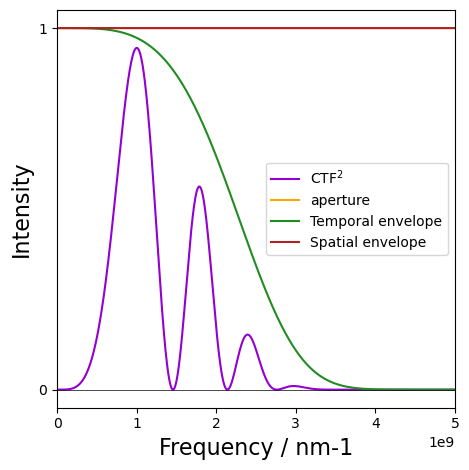

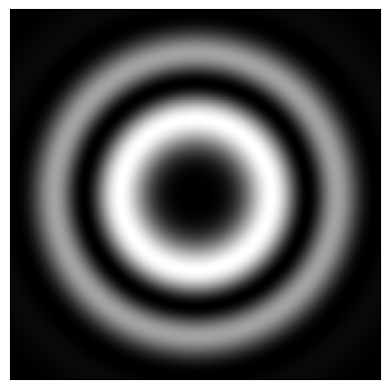

In [315]:
## Plot 1D CTF ##
fig, ax  = plt.subplots(1,1)
fig.figaspect=[1,2]
ax.plot(frequency, squareCTF, label='CTF$^2$', color='darkviolet')
# plot aperture function
ax.plot(frequency, aperture, label='aperture', color='orange')
# plot temporal envelope
ax.plot(frequency, Et, label='Temporal envelope', color='forestgreen')
# plot spatial envelope
ax.plot(frequency, Es, label='Spatial envelope', color='firebrick')
# axis settings
ax.axhline(0, color='black', linewidth=0.5)
plotSettings(fig, ax)

## Plot 2D CTF ##
fig, ax2  = plt.subplots(1,1)
ax2.imshow( square2DCTF, cmap='grey', extent=[-square2DCTF.shape[1]/2., square2DCTF.shape[1]/2., -square2DCTF.shape[0]/2., square2DCTF.shape[0]/2.])   
ax2.set_xticks([])
ax2.set_yticks([]) 

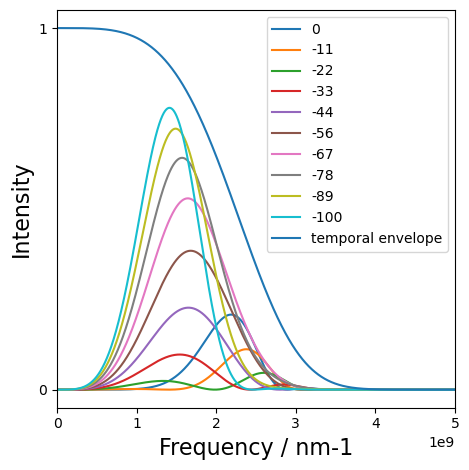

In [302]:
# This section simulates a 1D through-focus series
# simulate through-focus series
# defocus step in nm

# set the start, end, and step between defocus 
defocus_start = 0
defocus_end = -100
defocus_step = 10

defocus_range = np.linspace( defocus_start , defocus_end, defocus_step  )

through_focus_series = np.zeros([len(defocus_range), fno])

# calculate and return square of damped CTF
for i in range(0, len(defocus_range) ):
    CTF, dampedCTF, squareCTF, Es, Et, aperture, frequency = simulate1DCTF(lamb, flim, fno, defocus=defocus_range[i], Cs=1.8)
    through_focus_series[i] = np.array(squareCTF)

# plot the through-focus series and the temporal envelope
fig, ax = plt.subplots(1,1)
for i in range(0, len(defocus_range) ):
    ax.plot( frequency , through_focus_series[i], label = str(round(defocus_range[i])) )
ax.plot(frequency, Et, label='temporal envelope')

plotSettings( fig, ax )

#plt.plot(through_focus_series)
#polynomials = np.array([piston, tiltx, tilty, astig, astig45, defocus, comax, comay, spherical])

In [ ]:
# simulate through-focus series 2D
# defocus step in nm
# BE CAREFUL or you will save an insane number of images
# saves to current working directory
# have to set the scale manually when you open in DM

defocus_start = 200
defocus_end = -200
defocus_step = 20

defocus_range = np.linspace( defocus_start , defocus_end, defocus_step  )

through_focus_series_2d = np.zeros([image_size, image_size, len(defocus_range) ])

for i in range(0, len(defocus_range) ):
    CTF2d, square2DCTF = simulate2DCTF( lamb, flim, defocus=defocus_range[i], Cs=1.8, C12a=0, C12b=0,
                                  size=int(256), voltage=250 )
    through_focus_series_2d[:,:,i] = square2DCTF

through_focus_series_2d = np.float32(through_focus_series_2d)

for i in range(0, len(defocus_range) ):
    #plt.matshow( through_focus_series_2d[:, :, i], cmap='grey', extent=[-CTF2d.shape[1]/2., CTF2d.shape[1]/2., -CTF2d.shape[0]/2., CTF2d.shape[0]/2. ] )
    filename = str(i) + ".tiff"
    # save each slice as an image
    #cv2.imwrite( filename, through_focus_series_2d[:,:,i] )